In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import xgboost as xgb
import shap

# Load Dataset
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')  # Download from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

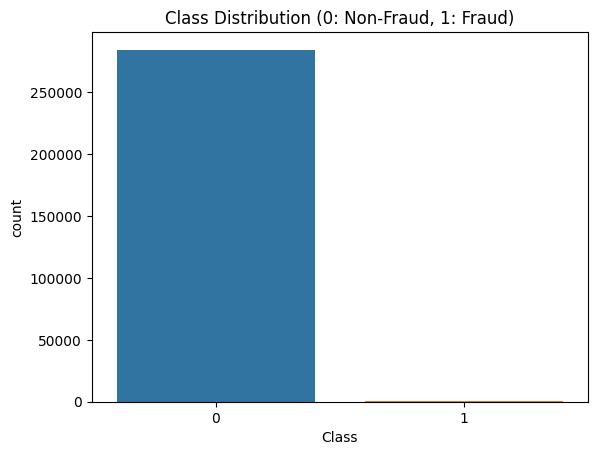

In [3]:
# Check the first 5 rows
print(df.head())

# Check dataset info
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Check class distribution
print(df['Class'].value_counts())

# Visualize class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


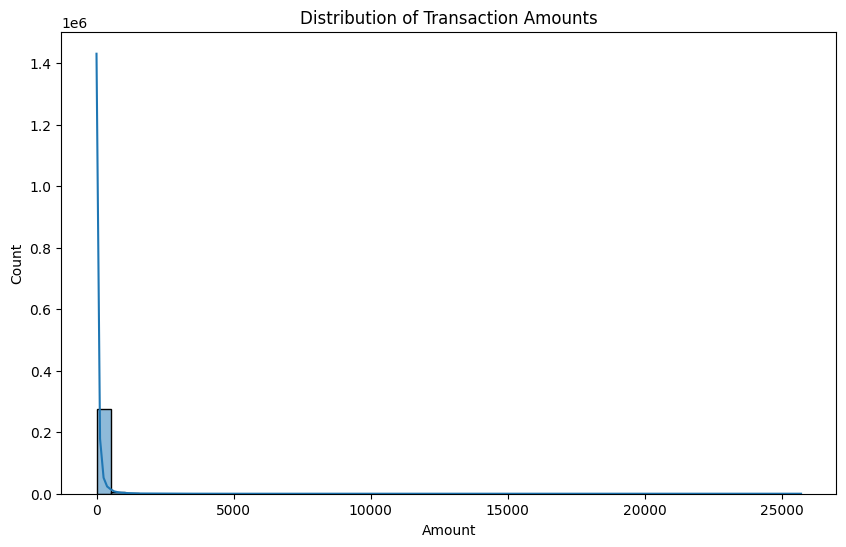

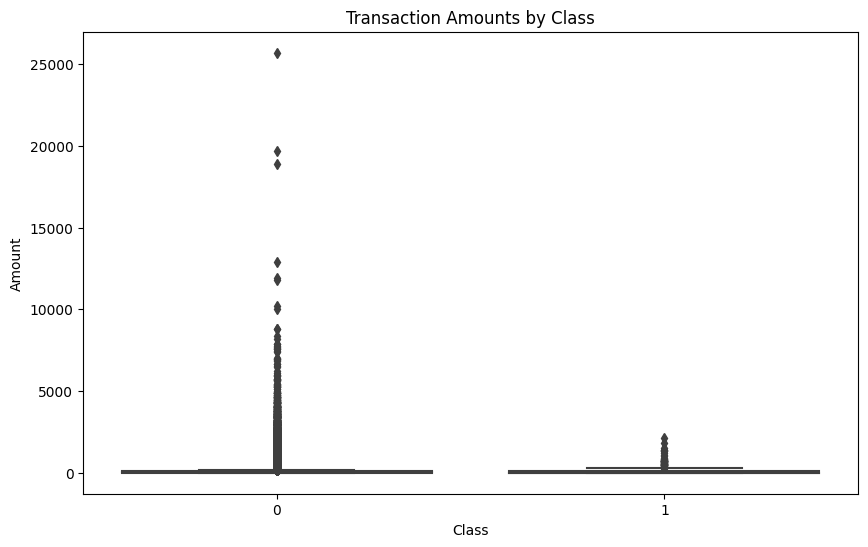

In [4]:
# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

# Transaction amounts by class
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amounts by Class')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


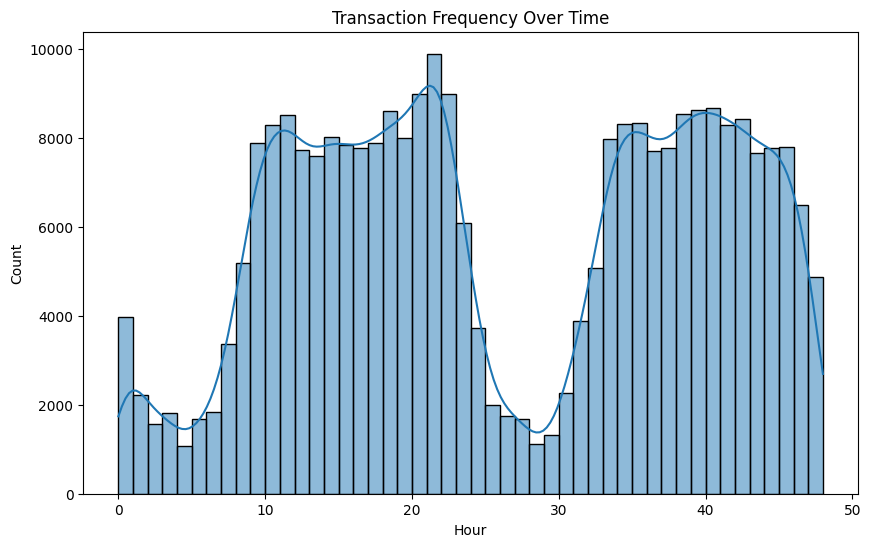

In [5]:
# Convert 'Time' to hours
df['Hour'] = df['Time'] / 3600

# Plot transactions over time
plt.figure(figsize=(10, 6))
sns.histplot(df['Hour'], bins=48, kde=True)
plt.title('Transaction Frequency Over Time')
plt.show()

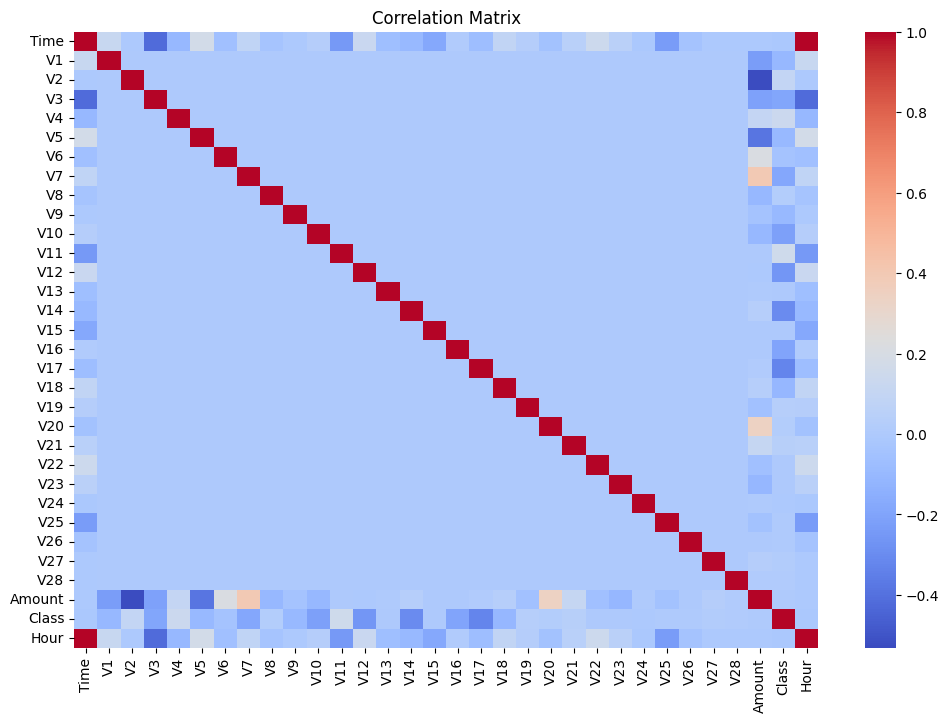

In [6]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

In [7]:
# Scale 'Amount' and 'Time'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])

In [8]:
# Split data into features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.78      0.85       136

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score: 0.8896648540668685


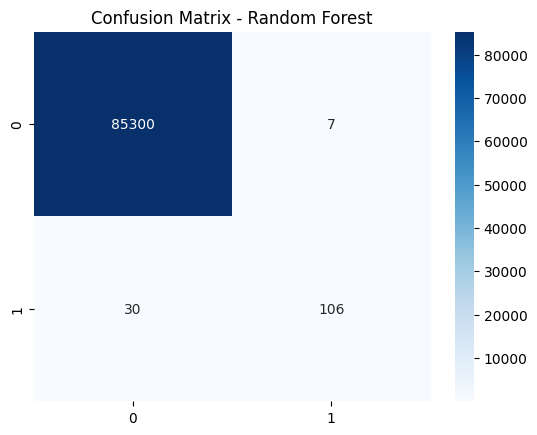

In [9]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score: 0.9080413458243203


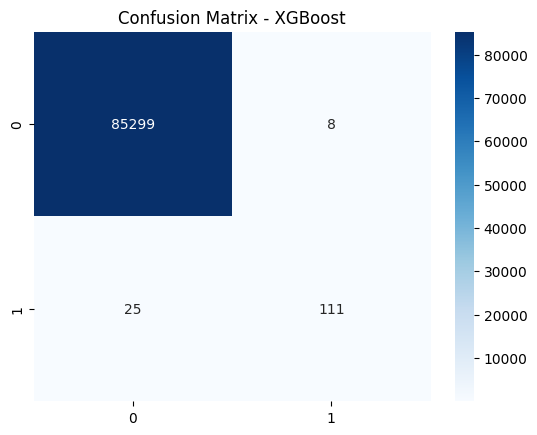

In [10]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_xgb))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.show()

   Feature  Importance
12     V12    0.141738
17     V17    0.139617
14     V14    0.111614
10     V10    0.092425
11     V11    0.085429
16     V16    0.055354
9       V9    0.042774
4       V4    0.025783
18     V18    0.025216
7       V7    0.023746
26     V26    0.016925
3       V3    0.016834
1       V1    0.016828
21     V21    0.015175
19     V19    0.014408
30    Hour    0.013536
6       V6    0.013443
27     V27    0.012996
15     V15    0.012432
29  Amount    0.012408
2       V2    0.012058
20     V20    0.011859
28     V28    0.011663
8       V8    0.011412
0     Time    0.010529
5       V5    0.009875
13     V13    0.009742
25     V25    0.009147
24     V24    0.008545
22     V22    0.008323
23     V23    0.008169


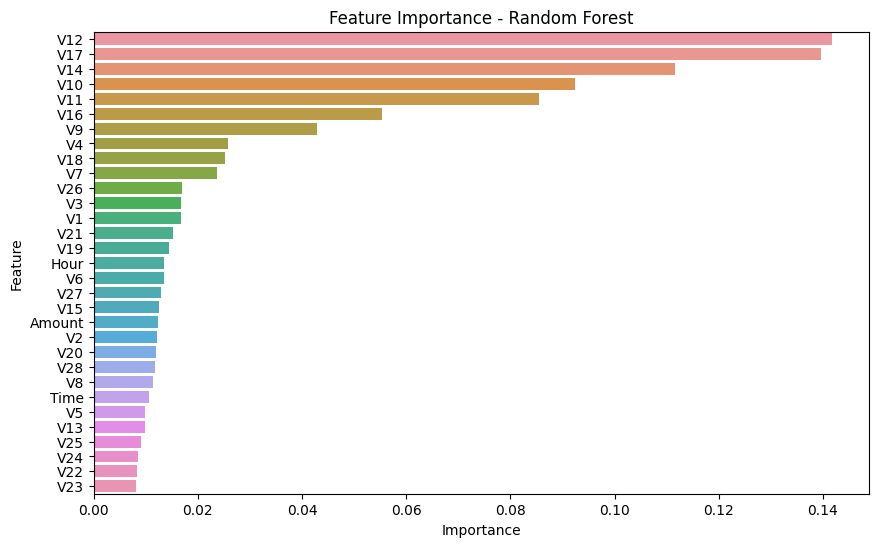

In [11]:
# Feature importance for Random Forest
feature_importance = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Random Forest')
plt.show()

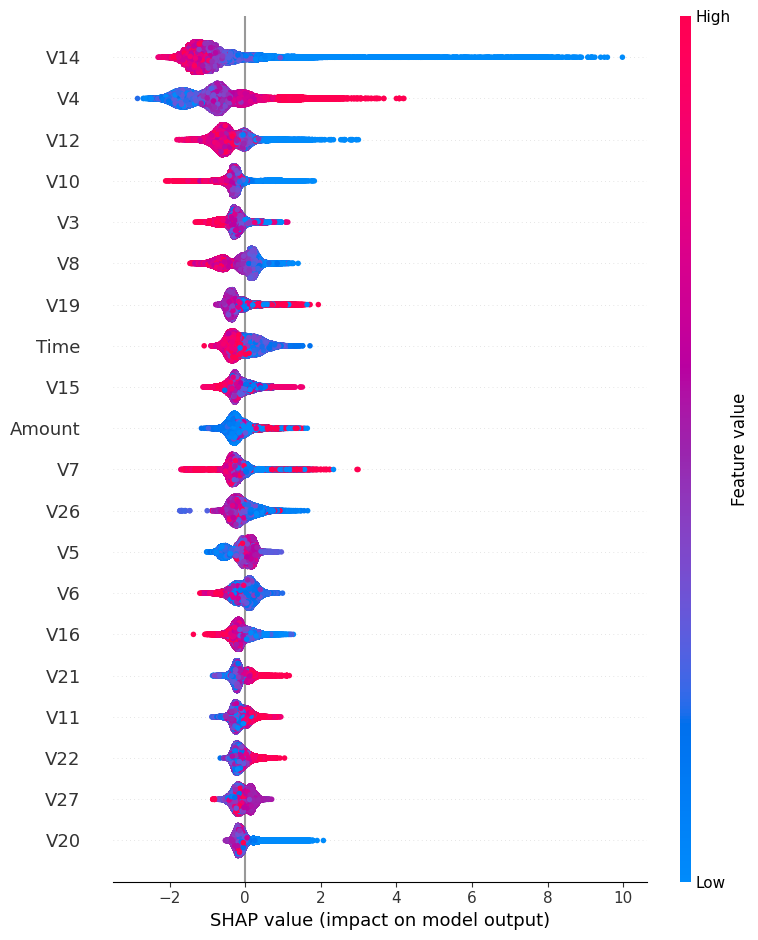

In [12]:
# SHAP explanation for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [13]:
# Identify high-risk transactions
high_risk_transactions = X_test[y_pred_xgb == 1]
print("High-Risk Transactions to Monitor:")
print(high_risk_transactions.head())

# Save high-risk transactions to CSV
high_risk_transactions.to_csv('high_risk_transactions.csv', index=False)

High-Risk Transactions to Monitor:
            Time         V1         V2         V3        V4         V5  \
43428  -1.122574 -16.526507   8.584972 -18.649853  9.505594 -13.793819   
116404 -0.432779  -2.250535   2.365755  -2.955491  0.089791  -2.830745   
215984  0.958012  -4.861747  -2.722660  -4.656248  2.502005  -2.008346   
77099  -0.798661  -0.075483   1.812355  -2.566981  4.127549  -1.628532   
15810  -1.422712 -25.942434  14.601998 -27.368650  6.378395 -19.104033   

              V6         V7         V8        V9  ...       V21       V22  \
43428  -2.832404 -16.701694   7.517344 -8.507059  ...  1.190739 -1.127670   
116404 -0.844462  -0.174062  -0.407138  0.174216  ...  0.256560 -0.466245   
215984  0.615422  -3.485680   1.878856 -1.116268  ...  1.138876  1.033664   
77099  -0.805895  -3.390135   1.019353 -2.451251  ...  0.794372  0.270471   
15810  -4.684806 -18.261393  17.052566 -3.742605  ...  1.784316 -1.917759   

             V23       V24       V25       V26       V27 

In [14]:
import joblib

# Save the model
joblib.dump(rf_model, 'credit_card_chargeback_model.pkl')

['credit_card_chargeback_model.pkl']

In [15]:
def predict_chargeback(new_data):
    # Load the model
    model = joblib.load('credit_card_chargeback_model.pkl')
    
    # Preprocess new data (e.g., scaling)
    new_data['Amount'] = scaler.transform(new_data[['Amount']])
    new_data['Time'] = scaler.transform(new_data[['Time']])
    
    # Make predictions
    predictions = model.predict(new_data)
    return predictions

In [16]:
import plotly.express as px

# Group transactions by hour and calculate fraud percentage
df['Hour'] = df['Time'] / 3600
hourly_fraud = df.groupby('Hour')['Class'].mean().reset_index()

# Plot high-risk transaction trends
fig = px.line(hourly_fraud, x='Hour', y='Class', title='High-Risk Transaction Trends Over Time',
              labels={'Class': 'Fraud Percentage', 'Hour': 'Transaction Hour'})
fig.show()